UNZIP THE DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
dataset_zip = "/content/drive/MyDrive/Dataset.zip"
dataset_dir = "/content/drive/MyDrive/Dataset"
training_dir = os.path.join(dataset_dir, "training")
validation_dir = os.path.join(dataset_dir, "validation")

# Check if training and validation directories exist
if not os.path.exists(training_dir) or not os.path.exists(validation_dir):
    print("Training or validation directory does not exist. Extracting the dataset...")
    with zipfile.ZipFile(dataset_zip, "r") as z:
        z.extractall(dataset_dir)
else:
    print("Training and validation directories already exist. Skipping extraction.")

Training or validation directory does not exist. Extracting the dataset...


RESNET 50 MODEL TRAINING UPTO 10 EPOCHS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from concurrent.futures import ThreadPoolExecutor

train data loaded
val data loaded
Epoch 1/10
10/10 [==============================] - 48s 2s/step - loss: 2.3155 - accuracy: 0.2873 - val_loss: 1.2669 - val_accuracy: 0.6851
Epoch 2/10
10/10 [==============================] - 14s 1s/step - loss: 1.1913 - accuracy: 0.5724 - val_loss: 1.1916 - val_accuracy: 0.7261
Epoch 3/10
10/10 [==============================] - 14s 1s/step - loss: 0.8202 - accuracy: 0.6910 - val_loss: 1.0371 - val_accuracy: 0.7317
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 0.5525 - accuracy: 0.7714 - val_loss: 0.9330 - val_accuracy: 0.7334
Epoch 5/10
10/10 [==============================] - 15s 1s/step - loss: 0.3735 - accuracy: 0.8255 - val_loss: 0.8988 - val_accuracy: 0.7324
Epoch 6/10
10/10 [==============================] - 15s 1s/step - loss: 0.2556 - accuracy: 0.8592 - val_loss: 0.8712 - val_accuracy: 0.7336
Epoch 7/10
10/10 [==============================] - 15s 2s/step - loss: 0.1821 - accuracy: 0.8882 - val_loss: 0.8546 - val_acc

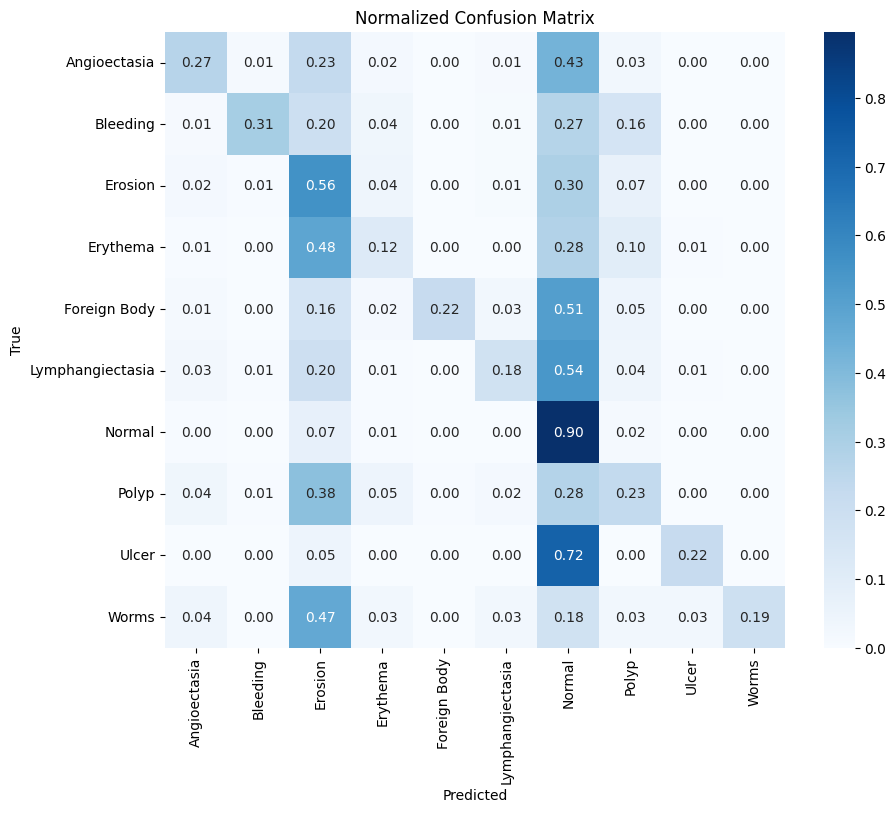

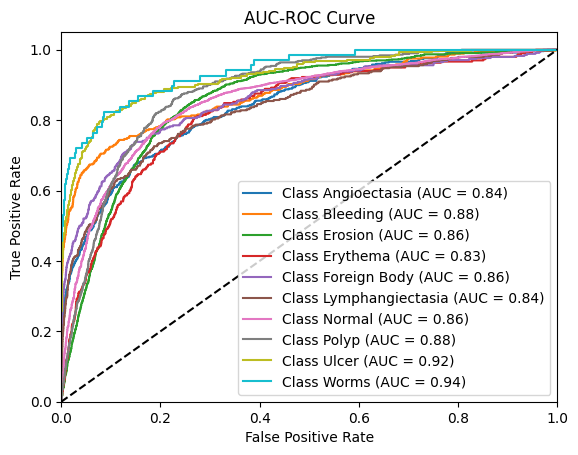

In [ ]:
def load_and_preprocess_image(base_dir, path, target_size):
    img_path = os.path.join(base_dir, path.replace('\\', '/'))
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    preprocessed_img = preprocess_input(img_array)
    return preprocessed_img

def get_data_for_training(excel_path, base_dir, image_size=(32, 32)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_names = df.columns[2:]
    X = np.array([load_and_preprocess_image(base_dir, path, image_size) for path in df['image_path'].values])
    y = df[class_names].values
    return X, y, df['image_path'].values

if __name__ == "__main__":
    train_excel_path = "/content/drive/MyDrive/Dataset/Dataset/training/training_data.xlsx"
    val_excel_path = "/content/drive/MyDrive/Dataset/Dataset/validation/validation_data.xlsx"
    base_dir = "/content/drive/MyDrive/Dataset/Dataset"
    image_size = (32, 32)
    batch_size = 4096
    epochs = 10

    # Load data for training and validation
    X_train, y_train, _ = get_data_for_training(train_excel_path, base_dir, image_size=image_size)
    print("train data loaded")
    X_val, y_val, image_paths = get_data_for_training(val_excel_path, base_dir, image_size=image_size)
    print("val data loaded")

    # Calculate class weights
    class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']
    y_train_labels = np.argmax(y_train, axis=1)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
    class_weights_dict = dict(enumerate(class_weights))

    #Build the model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(class_names), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights_dict
    )

    # Predict on the validation set
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_val_classes = np.argmax(y_val, axis=1)

    # Save validation predictions to an Excel file
    results_df = pd.DataFrame({
        'Image_path': image_paths,
        'actual_class': y_val_classes,
        'predicted_class': y_pred_classes
    })
    results_file_path = os.path.join(base_dir, "results.xlsx")
    results_df.to_excel(results_file_path, index=False, sheet_name='Sheet1')

    # Print the confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
    print(cm)

    # Print the classification report
    print("Classification Report:")
    print(classification_report(y_val_classes, y_pred_classes))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Plot AUC-ROC curve
    lb = LabelBinarizer()
    y_val_bin = lb.fit_transform(y_val_classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
        roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred[:, i])

    plt.figure()
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

# Binarize the true labels
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)

# Calculate AUC scores for each class
roc_auc = dict()
for i in range(len(class_names)):
    roc_auc[class_names[i]] = roc_auc_score(y_val_bin[:, i], y_pred[:, i])

# Print mean AUC score for each class
for class_name in class_names:
    print(f'Mean AUC for {class_name}: {roc_auc[class_name]:.2f}')


Mean AUC for Angioectasia: 0.84
Mean AUC for Bleeding: 0.88
Mean AUC for Erosion: 0.86
Mean AUC for Erythema: 0.83
Mean AUC for Foreign Body: 0.86
Mean AUC for Lymphangiectasia: 0.84
Mean AUC for Normal: 0.86
Mean AUC for Polyp: 0.88
Mean AUC for Ulcer: 0.92
Mean AUC for Worms: 0.94


SAVING THE MODEL

In [ ]:
import pickle

In [ ]:
base_dir = "/content/drive/MyDrive/Dataset/Dataset"
# Save the trained model using pickle
model_filename = os.path.join(base_dir, 'trained_model_resnet50.pkl')
with open(model_filename, 'wb') as model_file:
    pickle.dump(model, model_file)
print(f"Model saved to {model_filename}")

Model saved to /content/drive/MyDrive/Dataset/Dataset/trained_model_resnet50.pkl
